# Modelo de Identificação de Parcialidade em Notícias Jornalísticas


In [ ]:
"""
Mapeamento dos Arquivos
"""

BASE_GROUND_TRUTH = '/content/drive/MyDrive/Colab Notebooks/base_ground_truth.csv'

# TRAINING_SENTI_STRENGTH -> Base gerada a partir da analise do SentiStrength
TRAINING_SENTI_STRENGTH = '/content/drive/MyDrive/Colab Notebooks/base_training.csv'
# TRAINING_NAIVE_BAYES -> Base gerada a partir da analise do Naive Bayes
TRAINING_NAIVE_BAYES = '/content/drive/MyDrive/Colab Notebooks/base_training_naive_bayes.csv'

TRAINING = TRAINING_NAIVE_BAYES

MODEL_GENERATOR = True
EPOCHS = 7
BATCH_SIZE = 1000

MODEL_IN = '/content/drive/MyDrive/Colab Notebooks/model_naive_07.h5'
MODEL_OUT = '/content/drive/MyDrive/Colab Notebooks/model_naive_07.h5'

HISTORY_RESULTS = '/content/drive/MyDrive/Colab Notebooks/history_results_naive_07.csv'

WORD2VEC_S50 = '/content/drive/MyDrive/Colab Notebooks/word2vec_s50.txt'

### Importe das bibliotecas e carregamento das funções necessárias


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# coding: utf-8

import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from wordcloud import WordCloud
import pickle

from gensim.models import KeyedVectors

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.classify.naivebayes import NaiveBayesClassifier
from nltk.stem.rslp import RSLPStemmer

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Dense, LSTM, SpatialDropout1D, Bidirectional, Dropout
from keras.callbacks import EarlyStopping, CSVLogger

from sklearn.model_selection import train_test_split


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')

stopWords = set(stopwords.words('portuguese'))

"""
É descartado a palavra Não das StopWords pelo seu impacto no sentido da frase.
"""
stopWords.discard('não')



def clean_text(text):
    """
    Realiza a preparação do texto para ser utilizada
    Removendo pontuações, links, aspas e tornando tadas as letras em minúsculo
    Removendo as StopWords
    """

    text = re.sub(r'[^\w\s$]|http\S+', '', text).lower()
    text = text.replace(r'/[\'"]+/g', '')
    text = ' '.join(word for word in text.split() if word not in stopWords)
    
    return text

def create_embedding_matrix(vocab, n_words, emb_size):
    """
    Transformar o Word2Vec em uma matrix
    """

    pret_embedding = {}

    """
    Retorna uma nova matriz de forma e tipo fornecidos, preenchida com zeros.
    n_words - Tamanho da matriz
    emb_size - Comprimento de zeros
    """
    embedding_matrix = np.zeros((n_words, emb_size))
    count = 0

    """
    Dicionário com todos os ids e palavras do embedding pré-treinado
    Chave como a palavra buscada e Value como a chave de localização no Word2Vec
    """
    for index, word in enumerate(vocab.index2word):
        pret_embedding[word] = index

    # Construindo a embedding_matrix do embedding pré-treinado
    for item in pret_embedding.items():
        if item[1] < n_words:
            count += 1
            embedding_vector = vocab.word_vec(item[0])
            
            if embedding_vector is not None:
                embedding_matrix[item[1]] = embedding_vector
    
    return embedding_matrix

def create_x(tokens, embedding_model):
    """
    Buscar a localização dos tokens dentro do Word2Vec
    """

    list_x = []
    for token in tokens:
        if(token):
            if(token in embedding_model.vocab):
                list_x.append(embedding_model.vocab[token].index)
        
    return list_x

def predictModel(text, labels, Word2Vec, max_len, model):
    """
    Prepara um texto único e analizá-lo pelo o Modelo gerado
    """

    text = re.sub(r'[^\w\s$]|http\S+','', text).lower()
    text = word_tokenize(text)
    text = list(filter(lambda text: text not in stopWords, text))
    
    X = create_x(text, Word2Vec)
    X = pad_sequences(
        maxlen=max_len,
        sequences=[X],
        value=0,
        padding='post',
        truncating='post'
    )
    
    pred = model.predict(X)

    return labels[np.argmax(pred)]

def testModel(model_file, history_file, base_test):
    """
    Retorna a acurácia do Modelo Word2Vec baseado em uma base de dados
    """
    
    history_results = pd.read_csv(history_file, sep=';')
    epoc = len(history_results['accuracy'])

    model = load_model(model_file)
    outputs = [layer.output_shape[1] for layer in model.layers if type(layer) == Embedding]
    max_len = outputs[0]

    countErro = 0
    countAcerto = 0

    count = {
        'acerto': {
            'impartial': 0,
            'partial': 0,
        },
        'erro': {
            'impartial': 0,
            'partial': 0,
        }
    }

    lenData = len(base_test["article"])
    for i in range(lenData):
        predict = predictModel(
            base_test["article"][i], labels, Word2Vec, max_len, model
        )

        if(predict == base_test["type"][i]):
            countAcerto = countAcerto + 1
            count['acerto'][predict] = count['acerto'][predict] + 1
        else:
            countErro = countErro + 1
            count['erro'][base_test["type"][i]] = count['erro'][base_test["type"][i]] + 1

    porAcu = int((countAcerto / lenData)*100)
    porImp = int((count['acerto']['impartial'] / (count['acerto']['impartial'] + count['erro']['impartial']))*100)
    porPar = int((count['acerto']['partial'] / (count['acerto']['partial'] + count['erro']['partial']))*100)

    return {
        'model': model_file.replace('/content/drive/MyDrive/Colab Notebooks/',''),
        'total': porAcu,
        'impartial': porImp,
        'partial': porPar,
        'history': epoc,
    }
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [ ]:
# Carregar o Word Embedding Pré-Treinado
Word2Vec = KeyedVectors.load_word2vec_format(WORD2VEC_S50)

MAX_NB_WORDS = len(Word2Vec.vocab)
EMBEDDING_DIM = 50

print("\nTamanhos dos vocabulários:\n -> Word2Vec - " + str(MAX_NB_WORDS))



Tamanhos dos vocabulários:
 -> Word2Vec - 929606


### Preparação da Base de Treinamento

In [ ]:
train = pd.read_csv(TRAINING , sep=';', index_col=None, names=['article','type'])
train.head(2)


,article,type
0,"Geddel tem 33%, Otto, 29%, e Eliana, 4%, apont...",impartial
1,Presidente da AL-AP não acha verba 'desproporc...,impartial


In [ ]:
print("\nTamanhos da Base:\n -> Treinamento - " + str(len(train)))

labels = train['type'].value_counts().axes[0].tolist()
value_counts = train['type'].value_counts()

print("\nDetalhes:" +
      "\n -> Imparcial - " + str(value_counts[0]) +
      "\n -> Parcial - " + str(value_counts[1]))

train['article_clean'] = train['article'].apply(clean_text)

train['article_len'] = train['article_clean'].apply(lambda x : len(x))
max_len = int(train['article_len'].quantile(.75))

#75% do dataset pelo menos tem no maximo esse valor de tamanho
print("\nTamanhos Máximo das Notícias da Base:\n -> 75% do dataset - " + str(max_len))

train['article_tokens'] = train['article_clean'].apply(lambda text : word_tokenize(text.strip()) )
train['article_tokens_word2vec'] = train['article_tokens'].apply(lambda text : create_x(text, Word2Vec))

train.head(2)


Tamanhos da Base:
 -> Treinamento - 13020

Detalhes:
 -> Imparcial - 7410
 -> Parcial - 5610

Tamanhos Máximo das Notícias da Base:
 -> 75% do dataset - 2261


,article,type,article_clean,article_len,article_tokens,article_tokens_word2vec
0,"Geddel tem 33%, Otto, 29%, e Eliana, 4%, apont...",impartial,geddel 33 otto 29 eliana 4 aponta ibope instit...,884,"[geddel, 33, otto, 29, eliana, 4, aponta, ibop...","[36930, 10300, 22172, 3694, 14091, 719, 3209, ..."
1,Presidente da AL-AP não acha verba 'desproporc...,impartial,presidente alap não acha verba desproporcional...,404,"[presidente, alap, não, acha, verba, despropor...","[95, 127668, 18, 1004, 5765, 36682, 99, 8178, ..."


### Analise da Base

PALAVRAS EM DESTAQUE DA BASE


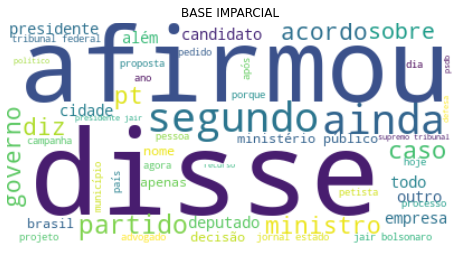

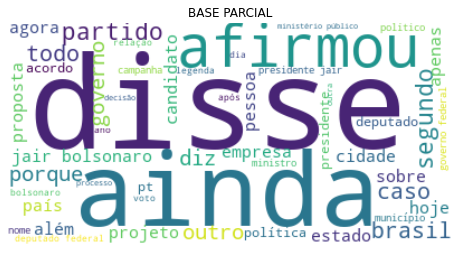

In [ ]:
print("PALAVRAS EM DESTAQUE DA BASE")

impartial_base = train[train['type'] == 'impartial']

impartial_unique_string = impartial_base['article_tokens'].apply(lambda text : (" ").join(text) )
impartial_frequency = FreqDist( impartial_unique_string )
impartial_word_dict = impartial_frequency.keys()

impartial_unique_string = (" ").join(impartial_word_dict)

wordcloud_impartial = WordCloud(
    stopwords=['não'],
    margin=0,
    max_words=50,
    background_color="white"
).generate( impartial_unique_string )

plt.figure(figsize=(8,6))
plt.title("BASE IMPARCIAL")
plt.imshow(wordcloud_impartial, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)



partial_base = train[train['type'] == 'partial']

partial_unique_string = partial_base['article_tokens'].apply(lambda text : (" ").join(text) )
partial_frequency = FreqDist( partial_unique_string )
partial_word_dict = partial_frequency.keys()

partial_unique_string = (" ").join(partial_word_dict)

wordcloud_partial = WordCloud(
    stopwords=['não'],
    margin=0,
    max_words=50,
    background_color="white"
).generate( partial_unique_string )

plt.figure(figsize=(8,6))
plt.title("BASE PARCIAL")
plt.imshow(wordcloud_partial, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)


### Preparação do MODELO

In [ ]:
if (MODEL_GENERATOR):
    embedding_matrix = create_embedding_matrix(Word2Vec, MAX_NB_WORDS, EMBEDDING_DIM)
    print(embedding_matrix.shape)


(929606, 50)


In [ ]:
if (MODEL_GENERATOR):
    # pad_sequences é usado para garantir que todas as sequências em uma lista tenham o mesmo comprimento.
    # o comprimento será o maior valor entre os 75% da base
    X = pad_sequences(
        maxlen=max_len,
        sequences=train['article_tokens_word2vec'],
        value=0,
        padding='post',
        truncating='post'
    )

    # pandas get_dummies transforma em valor binário
    # pd.get_dummies([impartial, partial, impartial])
    # result [ [1,0], [0,1], [1,0] ]
    Y = pd.get_dummies(train['type']).values
    print(X.shape, Y.shape)


(13020, 2261) (13020, 2)


In [ ]:
if (MODEL_GENERATOR):
    # train_test_split - Divide arrays ou matrizes em arrays menores, aleatórios e com subconjuntos de teste
    # test_size=0.20 - Reservado 20% para teste
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42, stratify=Y)
    
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    

(10416, 2261) (10416, 2)
(2604, 2261) (2604, 2)


In [ ]:
if (MODEL_GENERATOR):
    num_labels = Y.shape[1]

    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1], weights=[embedding_matrix]))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.1))
    model.add(Dense(num_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2261, 50)          46480300  
                                                                 
 spatial_dropout1d (SpatialD  (None, 2261, 50)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128)              58880     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 46,539,438
Trainable params: 46,539,438
No

In [ ]:
if (MODEL_GENERATOR):
    if Path(MODEL_IN).is_file():
        model.load_weights(MODEL_IN)
        

In [ ]:
if (MODEL_GENERATOR):
    history = model.fit(
        X_train,
        Y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001),
            CSVLogger(HISTORY_RESULTS, separator=';', append=True)
        ])

    accr = model.evaluate(X_test,Y_test)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

    model.save(MODEL_OUT)

Epoch 1/7
10/10 [==============================] - 267s 26s/step - loss: 0.6825 - accuracy: 0.5594 - val_loss: 0.6727 - val_accuracy: 0.5701
Epoch 2/7
10/10 [==============================] - 272s 28s/step - loss: 0.6691 - accuracy: 0.5819 - val_loss: 0.6578 - val_accuracy: 0.6286
Epoch 3/7
10/10 [==============================] - 230s 21s/step - loss: 0.6530 - accuracy: 0.6155 - val_loss: 0.6381 - val_accuracy: 0.6449
Epoch 4/7
10/10 [==============================] - 224s 23s/step - loss: 0.6271 - accuracy: 0.6434 - val_loss: 0.6256 - val_accuracy: 0.6526
Epoch 5/7
10/10 [==============================] - 234s 23s/step - loss: 0.6045 - accuracy: 0.6707 - val_loss: 0.6044 - val_accuracy: 0.6737
Epoch 6/7
10/10 [==============================] - 400s 20s/step - loss: 0.5664 - accuracy: 0.7004 - val_loss: 0.5732 - val_accuracy: 0.7457
Epoch 7/7
82/82 [==============================] - 23s 284ms/step - loss: 0.5687 - accuracy: 0.7289
Test set
  Loss: 0.569
  Accuracy: 0.729


### Analise Historico Modelo


Epocas do Modelo - 7


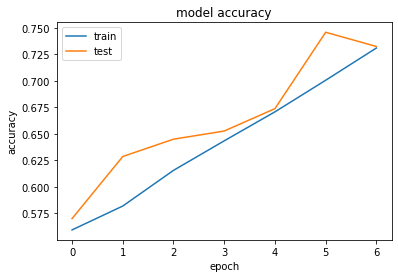

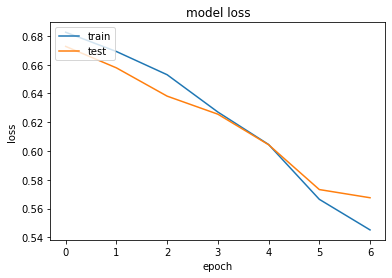

In [ ]:
history_results = pd.read_csv(HISTORY_RESULTS, sep=';')
print("\nEpocas do Modelo - " + str(len(history_results['accuracy'])) )

# summarize history for accuracy
plt.plot(history_results['accuracy'])
plt.plot(history_results['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_results['loss'])
plt.plot(history_results['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Preparar Base de Teste

In [ ]:
dataGROUNDTRUTH = pd.read_csv(BASE_GROUND_TRUTH, sep=';', index_col=None, names=['article','type', 'id', 'length', 'count_neutral_words'])

labels = dataGROUNDTRUTH['type'].value_counts().axes[0].tolist()
value_counts = dataGROUNDTRUTH['type'].value_counts()

lenData = len(dataGROUNDTRUTH["article"])
print("\nBase gerada por Humano:\n -> Tamanho: " + str(lenData))
print("\nDetalhes:" +
      "\n -> Imparcial - " + str(value_counts[0]) +
      "\n -> Parcial - " + str(value_counts[1]))

dataGROUNDTRUTH.head(2)



Base gerada por Humano:
 -> Tamanho: 282

Detalhes:
 -> Imparcial - 219
 -> Parcial - 63


,article,type,id,length,count_neutral_words
0,CPI da Covid suspende por 40 minutos sessão qu...,impartial,39,3,3
1,"Em meio a divergências, PT define oposição equ...",impartial,62,14,7


### Carregar modelo Naive Bayes

In [ ]:
stemmer: RSLPStemmer = RSLPStemmer()

f = open('/content/drive/MyDrive/Colab Notebooks/naive_bayes/impartiality_discovery_unique_words.pickle', 'rb')
uniqueWords = pickle.load(f)
f.close()

f = open('/content/drive/MyDrive/Colab Notebooks/naive_bayes/impartiality_discovery_classifier.pickle', 'rb')
classifier: NaiveBayesClassifier = pickle.load(f)
f.close()

countErro = 0
countAcerto = 0

count = {
    'acerto': {
        'impartial': 0,
        'partial': 0,
    },
    'erro': {
        'impartial': 0,
        'partial': 0,
    }
}
lenData = len(dataGROUNDTRUTH["article"])
for i in range(lenData):
    phrasesClean = []
    for (words) in dataGROUNDTRUTH["article"][i].split():
        words = re.sub(r'[^\w\s$]|http\S+','', words).lower()
        withStem = [ p for p in words.split() if p not in stopWords ]
        if(withStem):
            phrasesClean.append(str(stemmer.stem(withStem[0])))

    newPhrase = {}
    for words in uniqueWords:
        newPhrase['%s' % words] = (words in phrasesClean)

    predict = classifier.classify(newPhrase)
    if(predict == dataGROUNDTRUTH["type"][i]):
        countAcerto = countAcerto + 1
        count['acerto'][predict] = count['acerto'][predict] + 1
    else:
        countErro = countErro + 1
        count['erro'][dataGROUNDTRUTH["type"][i]] = count['erro'][dataGROUNDTRUTH["type"][i]] + 1

porAcu = int((countAcerto / lenData)*100)
porImp = int((count['acerto']['impartial'] / (count['acerto']['impartial'] + count['erro']['impartial']))*100)
porPar = int((count['acerto']['partial'] / (count['acerto']['partial'] + count['erro']['partial']))*100)

nv = {
    'model': "Naive Bayes",
    'total': porAcu,
    'impartial': porImp,
    'partial': porPar,
    'history': "-",
}


### Exibir Acuracia de todos os Modelos já treinados

In [ ]:
mapModels = [
    {
        'model': '/content/drive/MyDrive/Colab Notebooks/model_train_00.h5',
        'history': '/content/drive/MyDrive/Colab Notebooks/history_results_train_00.csv',
        'data': dataGROUNDTRUTH
     },
    {
        'model': '/content/drive/MyDrive/Colab Notebooks/model_train_01.h5',
        'history': '/content/drive/MyDrive/Colab Notebooks/history_results_train_01.csv',
        'data': dataGROUNDTRUTH
     },
    {
        'model': '/content/drive/MyDrive/Colab Notebooks/model_train_02.h5',
        'history': '/content/drive/MyDrive/Colab Notebooks/history_results_train_02.csv',
        'data': dataGROUNDTRUTH
     },
    {
        'model': '/content/drive/MyDrive/Colab Notebooks/model_train_03.h5',
        'history': '/content/drive/MyDrive/Colab Notebooks/history_results_train_03.csv',
        'data': dataGROUNDTRUTH
     },
    {
        'model': '/content/drive/MyDrive/Colab Notebooks/model_train_04.h5',
        'history': '/content/drive/MyDrive/Colab Notebooks/history_results_train_04.csv',
        'data': dataGROUNDTRUTH
     },
    {
        'model': '/content/drive/MyDrive/Colab Notebooks/model_naive_01.wv',
        'history': '/content/drive/MyDrive/Colab Notebooks/history_results_naive_01.csv',
        'data': dataGROUNDTRUTH
     },
    {
        'model': '/content/drive/MyDrive/Colab Notebooks/model_naive_02.wv',
        'history': '/content/drive/MyDrive/Colab Notebooks/history_results_naive_02.csv',
        'data': dataGROUNDTRUTH
     },
    {
        'model': '/content/drive/MyDrive/Colab Notebooks/model_naive_03.h5',
        'history': '/content/drive/MyDrive/Colab Notebooks/history_results_naive_03.csv',
        'data': dataGROUNDTRUTH
     },
    {
        'model': '/content/drive/MyDrive/Colab Notebooks/model_naive_04.h5',
        'history': '/content/drive/MyDrive/Colab Notebooks/history_results_naive_04.csv',
        'data': dataGROUNDTRUTH
     },
    {
        'model': '/content/drive/MyDrive/Colab Notebooks/model_naive_05.h5',
        'history': '/content/drive/MyDrive/Colab Notebooks/history_results_naive_05.csv',
        'data': dataGROUNDTRUTH
     },
    {
        'model': '/content/drive/MyDrive/Colab Notebooks/model_naive_06.h5',
        'history': '/content/drive/MyDrive/Colab Notebooks/history_results_naive_06.csv',
        'data': dataGROUNDTRUTH
     },
    {
        'model': MODEL_OUT,
        'history': HISTORY_RESULTS,
        'data': dataGROUNDTRUTH
     },
]

df = pd.DataFrame(columns=['model', 'total', 'impartial', 'partial', 'history'])
df = df.append(nv, ignore_index=True)

for mapModel in mapModels:
    df = df.append(
        testModel(
            mapModel['model'],
            mapModel['history'],
            mapModel['data']
    ), ignore_index=True)

df

,model,total,impartial,partial,history
0,Naive Bayes,77,93,23,-
1,model_train_00.h5,69,68,73,10
2,model_train_01.h5,74,79,55,7
3,model_train_02.h5,70,67,79,7
4,model_train_03.h5,69,68,69,8
5,model_train_04.h5,70,73,61,5
6,model_naive_01.wv,69,72,61,5
7,model_naive_02.wv,73,78,58,5
8,model_naive_03.h5,74,75,68,7
9,model_naive_04.h5,70,70,69,7


# Modelos Treinados

SentiStrength
- Acurácia Total: 56%

Naive Bayes
- Acurácia Total: 77%
- Acurácia Imparcial: 93%
- Acurácia Parcial: 23%

Model_train_01.h5 - 7 Epocas
- Acurácia Total: 74%
- Acurácia Imparcial: 79%
- Acurácia Parcial: 55%

Model_naive_03.h5 - 7 Epocas
- Acurácia Total: 74%
- Acurácia Imparcial: 75%
- Acurácia Parcial: 68%